# Image Classification from Scratch

This book contains image classification from scratch leveraging the superiority of Convolutional Neural Network (CNN).

The dataset is based on ['Vegetable Image Dataset'](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset).

Ahmed, M. Israk & Mamun, Shahriyar & Asif, Asif. (2021). DCNN-Based Vegetable Image Classification Using Transfer Learning: A Comparative Study. 235-243. 10.1109/ICCCSP52374.2021.9465499.

In [1]:
!pip install pillow tensorflow numpy

In [14]:
import requests;
import time;
from pathlib import Path;
import os;
import numpy;

import tensorflow;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D;
from tensorflow.keras.applications import VGG19;

from PIL import Image;
from numpy import asarray;

import matplotlib.pyplot as plt;

from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;

from tensorflow.keras.regularizers import l2, l1_l2;

from google.colab import drive;

In [5]:
# Check whether the GPU is exist
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Directory configuration
drive.mount('/content/drive');

base_path = "/content/drive/MyDrive/Collab Dataset/Vegetable Images";
train_path = base_path + "/train";
test_path = base_path + "/test";
val_path = base_path + "/validation";

Mounted at /content/drive


## Dataset Pre-Processing

Regarding the nature of the data with structures as below:

```
Vegetable Images
|- validation
  |- label1
    |- image1
    |- imagen
  |- labeln
|- train
|- test
```

Therefore, the pre-processing leveraging the folder structure is needed by applying algorithm below:

```
dataset = [feature_train = [], feature_test = [], feature_val = []]
labels = [label_train = [], label_test = [], label_val = []]

FOR idx, everything IN ENUMERATE([train, test, validation])
  FOR folder IN everything
    SET label = folder.name
    
    FOR file IN folder
      APPEND dataset[idx], CONVERT_FILE_TO_ARRAY(file)
      APPEND labels[idx], label
```

Basically:

1. Convert the dataset from image format into float array format.
2. Make enumeration from the label dataset since Tensorflow only can retrieve "Tensor". The rule below are applied:
> 1: Brocolli
> 2: Cabbage
> 3: Cauliflower
3. Save the converted dataset to the float array of `dataset_feature`.
4. Set the folder name as its data label of the converted feature.
5. Save the label to `dataset_label`.
6. Perform OneHotEncoding to all dataset_label.

In [7]:
dataset_feature = [
    [], # Train
    [], # Test
    []  # Val
];

dataset_label = [
    [], # Train
    [], # Test
    []  # Val
];

for idx, e in enumerate([train_path, test_path, val_path]):
  folders = Path(e).glob("*");

  # Navigate to folder
  for folder in folders:
    folder_name = os.path.basename(folder);
    if(folder_name in ["Broccoli", "Cabbage", "Cauliflower"]):
      label = 0;
      match(folder_name):
        case "Broccoli":
          label = 0;

        case "Cabbage":
          label = 1;

        case "Cauliflower":
          label = 2;


      # Get all files by navigating to folder
      files = Path(folder).glob("*");

      # Mapping and convert features with the corresponding label
      for file in files:
        image = Image.open(Path(file));

        # Convert feature from image to tensor
        converted_tensor_from_image = asarray(image);
        converted_tensor_from_image = converted_tensor_from_image / 255.0;

        # Load the dataset to the list
        dataset_feature[idx].append(converted_tensor_from_image);
        dataset_label[idx].append(label);

  # Perform One-Hot Encoding for the dataset_label
  dataset_label[idx] = tensorflow.one_hot(dataset_label[idx], depth = 3);

train_images = dataset_feature[0];
test_images = dataset_feature[1];
val_images = dataset_feature[2];
train_labels = dataset_label[0];
test_labels = dataset_label[1];
val_labels = dataset_label[2];

## Data Exploration

This exploration endavour taking feature data shape to make an exact model architecture

In [8]:
print("Training dataset shape: ")

print("Total dataset, width, height")

print(len(train_images), len(train_images[0]), len(train_images[0][0]))
print(len(train_labels), len(train_labels[0]));

print(len(test_images), len(test_images[0]), len(test_images[0][0]))
print(len(test_labels), len(test_labels[0]));

print(len(val_images), len(val_images[0]), len(val_images[0][0]))
print(len(val_labels), len(val_labels[0]));

train_images = numpy.array(train_images);
test_images = numpy.array(test_images);
val_images = numpy.array(val_images);
train_labels = numpy.array(train_labels);
test_labels = numpy.array(test_labels);
val_labels = numpy.array(val_labels);

Training dataset shape: 
Total dataset, width, height
3000 224 224
3000 3
600 224 224
600 3
600 224 224
600 3


## Support Functions

### 1. Telegram Reporter

This notebook filled with helper to report whether training is started or stopped.

In [9]:
# telegram_reporter
"""
This function helps to send message to telegram private channel
"""
def telegram_reporter(message):
    message = "[" + time.strftime("%Y-%m-%d %H:%M:%S") +"][CNN FROM SCRATCH] " + message
    requests.request(
        method="POST",
        url="https://api.telegram.org/bot{YeheheBoi}/sendMessage?chat_id={YeheheBoi}&text=" + message,
        headers={},
        data={}
    );

## Model Architecture

In [15]:
class VGG_Network:

  def __init__(self):
    self.vgg = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    );

    self.global_pool = GlobalAveragePooling2D();
    self.dense = Dense(64, activation = "relu", kernel_regularizer = l2(1e-4));

    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 5;
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
    model = Sequential();

    model.add(self.vgg);
    model.add(self.global_pool);
    model.add(self.dense);
    model.add(self.output);

    model.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["accuracy"]);
    model.summary();

    plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


    history = model.fit(
        train_images,
        train_labels,
        epochs = 25,
        batch_size = 64,
        validation_data = (val_images, val_labels),
        callbacks = [self._callback_early_stopping()]
    );

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss');
    plt.plot(history.history['val_loss'], label='Validation Loss');
    plt.xlabel('Epoch');
    plt.ylabel('Loss');
    plt.legend();
    plt.show();

    return model;

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 20057411 (76.51 MB)
Trainable params: 20057411 (76.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
47/47 [==============================] - 30s 372ms/step - loss: 0.9

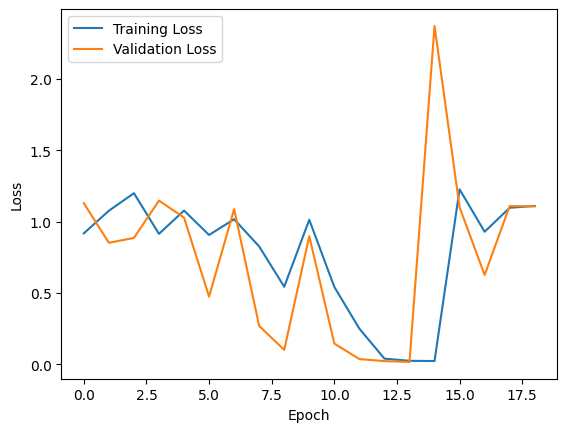

19/19 [==============================] - 2s 26ms/step - loss: 0.0217 - accuracy: 0.9983
Test accuracy: 0.9983333349227905


In [16]:
telegram_reporter("Starting training");

vgg = VGG_Network();
model = vgg.fitting();

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

telegram_reporter("Training done");
